# Speaker Diarization of a Podcast Episode

This notebook demonstrates how to segment a podcast episode by speakers using `pyannote.audio`.

## Settings

In [1]:
from audiomariner.util import get_secret

In [2]:
token_huggingface = get_secret("token_huggingface")

In [3]:
from pathlib import Path

In [4]:
example_short_podcast_path = Path("../data/audio/temp/agi-is-far-away.mp3")
example_long_podcast_path = Path("../data/audio/temp/lex_ai_yann_lecun_3.mp3")
example_podcast_path = example_short_podcast_path

In [5]:
import torch

if torch.backends.mps.is_available():
    print("MPS is available")
else:
    print("MPS is not available")

MPS is available


## Diarization Pipeline

In [6]:
from pyannote.audio import Pipeline


/Users/cls/miniforge3/envs/audiomariner2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Initialize the diarization pipeline
diarization_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=token_huggingface,
)

torchvision is not available - cannot save figures


In [8]:
from pydub import AudioSegment
import io
from typing import IO

def load_mp3_for_pyannote(mp3_file_path: str) -> IO[bytes]:
    """
    Convert an MP3 file to WAV format in memory and return an in-memory file-like object.

    Args:
    mp3_file_path (str): The path to the MP3 file.

    Returns:
    IO[bytes]: An in-memory file-like object containing the WAV data.
    """
    # Load the MP3 file
    audio = AudioSegment.from_mp3(mp3_file_path)
    
    # Create an in-memory bytes buffer
    wav_io = io.BytesIO()
    
    # Export the audio to WAV format, in-memory
    audio.export(wav_io, format="wav")

    # Seek to the start of the BytesIO buffer
    wav_io.seek(0)

    return wav_io

In [9]:
example_podcast = load_mp3_for_pyannote(example_podcast_path)

In [10]:
diarization_pipeline.to(torch.device("mps"))


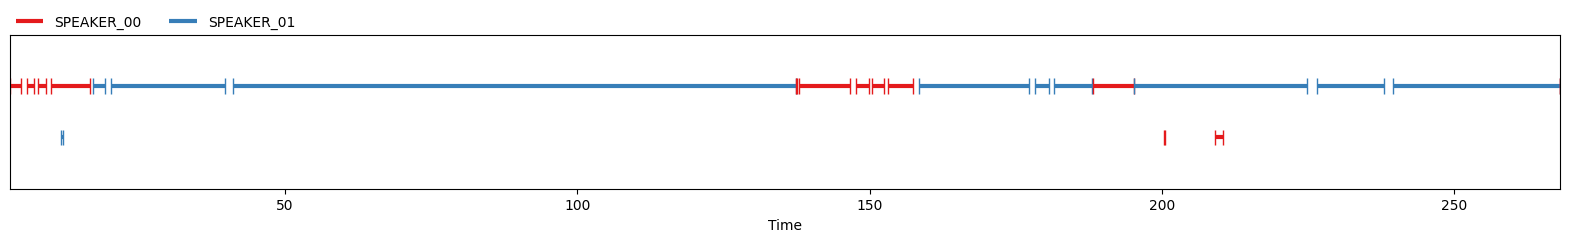

In [12]:
example_diarization = diarization_pipeline(
    example_podcast
)
example_diarization

In [13]:
from pandas import DataFrame, Series

def diarization_result_to_dataframe(diarization):
    """
    Convert a diarization result to a pandas DataFrame.
    
    Parameters:
    diarization (pyannote.core.Annotation): Diarization result from pyannote.
    
    Returns:
    pd.DataFrame: DataFrame with columns 'start', 'end', and 'speaker'.
    """
    # Extract diarization data into a list of dictionaries
    data = []
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        data.append({
            'start': turn.start,
            'end': turn.end,
            'speaker': speaker
        })

    # Convert list of dictionaries to pandas DataFrame
    data = DataFrame(data)

    return data

In [15]:
example_diarization_data = diarization_result_to_dataframe(example_diarization)
example_diarization_data

,start,end,speaker
0,2.967219,4.823469,SPEAKER_00
1,5.869719,7.084719,SPEAKER_00
2,7.742844,9.194094,SPEAKER_00
3,9.987219,16.619094,SPEAKER_00
4,11.708469,11.961594,SPEAKER_01
5,17.159094,19.251594,SPEAKER_01
6,20.297844,39.754719,SPEAKER_01
7,41.155344,137.444094,SPEAKER_01
8,137.460969,137.579094,SPEAKER_00
9,137.882844,146.640969,SPEAKER_00


<Axes: ylabel='speaker'>

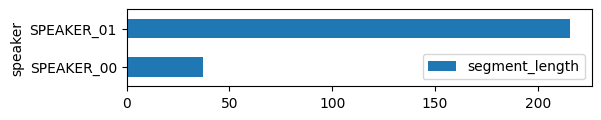

In [20]:
example_diarization_data["segment_length"] = example_diarization_data["end"] - example_diarization_data["start"]
(
    example_diarization_data[["speaker", "segment_length"]]
    .groupby("speaker")
    .sum()
    .plot(kind="barh", figsize=(6,1))
)